# Simulation of the Z Path

The primary goal of the current simulation is to use and validate for the first time the core analysis logic before applying it to real, complex data from LHC. The simulation is a kind of unit test for the physics logic necessary before moving on to the actual search for the rare $H\to 4\mathcal{l}$ decay.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# In a real environment, 'uproot' and 'vector' would be used here.
# import uproot 
# import vector 

## Four-Momentum Class (Simulation)
It is required for invariant mass calculation $M_{inv}= \sqrt{(E^2 - p^2)}$. The class will enable us to calculate easily the invariant mass.

Our class is a simplified simulation because it does not maintain the strict, consistent relationship between all the input kinematic variables that a real, specialized physics library would.

Real-world libraries (like the vector library) automatically calculate the Cartesian momentum components $(p_x​,p_y​,p_z​)$ based on $p_T​,\nu,\phi$. For a massless particle, the energy E would be calculated directly from the magnitude of the momentum, ∣p​∣. For a massive particle, E is calculated using the known mass M and momentum magnitude: 

$E=\sqrt{M_{inv}^2+∣p​∣^2}​$.

In our simplified class, we take E as a separate, independent input (passed directly in the __init__ function).It means the overall energy E we use in the final mass calculation is the input E, not one strictly derived from the other momentum inputs. This allows us to force the particle properties for the simulation to intentionally create a Z peak (by setting $E_1​=51$ and $E_2​=70$).

In [2]:
class FourMomentum:
    """Simplified simulation of a four-momentum (E, px, py, pz) for mass calculation."""
    def __init__(self, pt, eta, phi, E, charge=0, flavor=0):
        # Simplified conversion (real code would the vector library)
        self.E = E
        self.px = pt * np.cos(phi)
        self.py = pt * np.sin(phi)
        self.pz = pt * np.sinh(eta)
        self.charge = charge
        self.flavor = flavor
    
    def __add__(self, other):
        # Returns a new four-momentum which is the sum
        sum_vec = FourMomentum(0, 0, 0, 0)
        sum_vec.E = self.E + other.E
        sum_vec.px = self.px + other.px
        sum_vec.py = self.py + other.py
        sum_vec.pz = self.pz + other.pz
        return sum_vec

    def mass_squared(self):
        """Calculates the invariant mass squared"""
        p_sq = self.px**2 + self.py**2 + self.pz**2
        return self.E**2 - p_sq

    def mass(self):
        """Returns the invariant mass"""
        m_sq = self.mass_squared()
        return np.sqrt(max(0, m_sq)) 

## Data Simulation Function

### Physics Behind Mock Data Generation

These lines generate a particle's **four-momentum** (Lorentz Vector) and its **identity** for a simulated event. They rely on the cylindrical coordinate system used by LHC detectors.

#### 1. Kinematic Variables

The momentum of a particle is typically described using Transverse Momentum ($p_T$), Pseudorapidity ($\eta$), and Azimuthal Angle ($\phi$).

| Code Line | Kinematic Variable | Physical Meaning and Rationale |
| :--- | :--- | :--- |
| `pt = np.random.uniform(5, 50)` | **Transverse Momentum ($\mathbf{p_T}$)** | The momentum component perpendicular to the beam line (the $z$-axis). This is the momentum most reliably measured by the inner tracker. The range $\mathbf{[5, 50 \text{ GeV}]}$ simulates leptons energetic enough to pass typical quality cuts. |
| `eta = np.random.uniform(-2.5, 2.5)` | **Pseudorapidity ($\mathbf{\eta}$)** | A proxy for the particle's angle relative to the beam line. $\eta=0$ is perpendicular and $|\eta| = 2.5$ is near the edge of the detector's central barrel. The range $\mathbf{[-2.5, 2.5]}$ ensures the particle is within the detector's **acceptance**. |
| `phi = np.random.uniform(-np.pi, np.pi)` | **Azimuthal Angle ($\mathbf{\phi}$)** | The angle around the beam axis. Collisions are symmetrical around this axis, so $\phi$ is uniformly distributed across $\mathbf{[-\pi, \pi]}$ radians. |

#### 2. Particle Identification

| Code Line | Particle Property | Physical Meaning and Rationale |
| :--- | :--- | :--- |
| `charge = np.random.choice([1, -1])` | **Electric Charge ($Q$)** | The charge is either positive ($+1$) or negative ($-1$). This is vital for the **SFOS (Same-Flavor, Opposite-Sign)** selection rule used to find $Z$ boson candidates. |
| `flavor = np.random.choice([11, 13])` | **Lepton Flavor (ID)** | These are **PDG Codes** (Particle Data Group). **11** is an electron ($e$), and **13** is a muon ($\mu$). We use these to enforce the **Same-Flavor** requirement for $Z \rightarrow \ell^+\ell^-$. |

#### 3. Simplified Energy Calculation

The line `E = pt * np.cosh(eta) * 1.05` calculates the particle's total Energy (E) based on a relativistic approximation.

For a particle, the total momentum magnitude $∣p​∣$ is related to its transverse momentum ($p_T$​) and pseudorapidity ($\nu$) by the formula [^LHC_CLOSER]:
$$|\vec{p}| = p_T \cdot \cosh(\eta) $$

Since leptons ($e$ and $\mu$) have tiny masses ($m_0 \approx 0$), we use the approximation from Special Relativity (because $p>>m$): $$E \approx |\vec{p}| $$

Substituting the relation for $|\vec{p}|$ into the approximation: 
$$E \approx p_T \cdot \cosh(\eta) $$

The final factor, 1.05 ensures that the generated energy E is slightly larger than the momentum to guarantees that $M^2=E^2−∣p​∣^2>0$, preventing mathematical errors, and simulates the tiny, non-zero mass of real leptons.
### Creating a Z candidate
The total invariant mass $M$ must equal $91.2 \text{ GeV}$.

We use the formula $M^2 = E_{\text{tot}}^2 - |\vec{P}_{\text{tot}}|^2$.

The constraints $\mathbf{p_T}, \mathbf{\eta}, \mathbf{\phi}$ values fix the total momentum squared $|\vec{P}_{\text{tot}}|^2$ to a constant value (approximately $\mathbf{6400 \text{ GeV}^2}$, calculated with our FourMomentum Class for eg).

To satisfy the equation $91.2^2 = E_{\text{tot}}^2 - 6400$, the required total energy is $\mathbf{E_{\text{tot}}} \approx \mathbf{121 \text{ GeV}}$. We distribute this as $51 \text{ GeV} + 70 \text{ GeV}$ to reflect an asymmetric decay, ensuring $L_2$ has more energy to match its higher $p_T$.

[^LHC_CLOSER]: https://www.lhc-closer.es/taking_a_closer_look_at_lhc/0.momentum


In [ ]:
def generate_event(is_z_candidate=False):
    """
    Generates lepton data to simulate an event.
    If is_z_candidate is True, increases the chance of having a valid Z pair.
    """
    num_leptons = np.random.randint(2, 6) # Variable number of leptons per event
    leptons = []

    for i in range(num_leptons):
        pt = np.random.uniform(5, 50)
        eta = np.random.uniform(-2.5, 2.5)
        phi = np.random.uniform(-np.pi, np.pi)
        charge = np.random.choice([1, -1])
        flavor = np.random.choice([11, 13]) # 11=e, 13=mu

        E = pt * np.cosh(eta) * 1.05 # Energy based on a relativistic approximation

        lv = FourMomentum(pt, eta, phi, E, charge, flavor)
        leptons.append(lv)
    
    # Add a 'good' quality Z pair to 10% of the events to simulate the signal
    if is_z_candidate and num_leptons < 6: # num_leptons < 6 condition useless for this simuation, but will be useful in real env.
        # Create an artificial SFOS pair with mass close to 91 GeV
        pt1, pt2 = 35, 45 
        eta1, eta2 = 0.5, -0.5
        phi1, phi2 = 0.1, -0.1
        
        E1, E2 = 51, 70 # Adjusted so E_tot = 121 GeV, calculated to center peak at ~91 GeV.
        charge1, charge2 = 1, -1
        flavor = np.random.choice([11, 13])
        
        leptons.append(FourMomentum(pt1, eta1, phi1, E1, charge1, flavor))
        leptons.append(FourMomentum(pt2, eta2, phi2, E2, charge2, flavor))
        
    return leptons


## Generating the events
We make about 20% of z_candidat in all candidats generated. This value is hight, but is just a simution to check the code. In real env, the percent should be about 1% !

In [ ]:
# Generate 2000 test events for better statistics
NUM_EVENTS = 2000
events_data = [generate_event(is_z_candidate=(i % 5 == 0)) for i in range(NUM_EVENTS)]

## Functions for Z reconstruction

In [5]:
def apply_minimal_lepton_cuts(lepton):
    """Applies minimal cuts for leptons (pT and eta)."""
    # pT > 5 GeV (Standard baseline cut)
    pt = np.sqrt(lepton.px**2 + lepton.py**2)
    if pt < 5:
        return False
    # |eta| < 2.5 (Detector region)
    # Since the eta approximation in FourMomentum class is not exact,
    # we use a simple absolute cut for the simulation
    # The actual calculation for rapidity is needed in real analysis.
    if abs(lepton.pz) / pt > 2.5: 
        return False
    return True

def find_sfos_pairs(leptons):
    """
    Finds all Same-Flavor Opposite-Sign (SFOS) pairs that pass 
    the minimal cuts.
    """
    sfos_pairs = []
    # First, filter leptons that pass the baseline cuts
    qualified_leptons = [l for l in leptons if apply_minimal_lepton_cuts(l)]
    
    for i in range(len(qualified_leptons)):
        for j in range(i + 1, len(qualified_leptons)):
            l1 = qualified_leptons[i]
            l2 = qualified_leptons[j]
            
            # 1. Same Flavor
            is_same_flavor = (l1.flavor == l2.flavor)
            # 2. Opposite Charge
            is_opposite_charge = (l1.charge != l2.charge)
            
            if is_same_flavor and is_opposite_charge:
                sfos_pairs.append((l1, l2))
                
    return sfos_pairs

def calculate_M_inv(l1, l2):
    """Calculates the invariant mass for a pair of leptons (Z candidate)."""
    # Uses the .mass() method of the combined LorentzVector class
    combined_lv = l1 + l2
    return combined_lv.mass()


## Main Validation Loop

First, we find all SFOS pairs with the selection functions written above.

The  2nd and 3rd step guarantees that even the weakest virtual Z∗ has enough energy to be considered the product of a significant decay from a heavy particle such as the Higgs. The issue we solve here is that there are many background processes that produce low-mass lepton pairs :
- The J/ψ resonance: M≈3.1 GeV
- The Υ resonance: M≈9.5 GeV

In [8]:
sfos_masses = []

for event_index, leptons in enumerate(events_data):
    # Step 1: Find all SFOS pairs
    sfos_pairs = find_sfos_pairs(leptons)
    
    for l1, l2 in sfos_pairs:
        # Step 2: Calculate invariant mass
        M_ll = calculate_M_inv(l1, l2)
        
        # Step 3: Validation cut (typically M_ll > 12 GeV)
        if M_ll > 12: 
            sfos_masses.append(M_ll)
            
print(f"Retained SFOS pairs (Potential Z candidates): {len(sfos_masses)}")

Retained SFOS pairs (Potential Z candidates): 1894


## Z Peak visualization

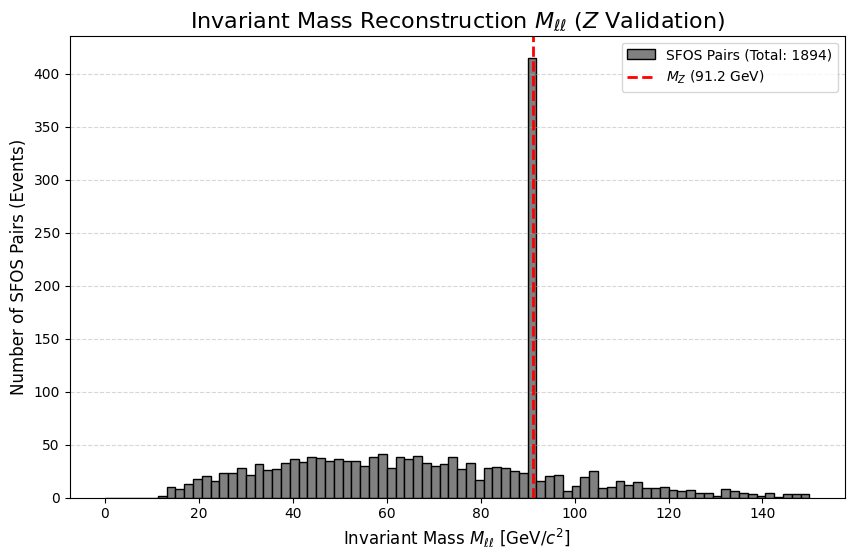

In [7]:
plt.figure(figsize=(10, 6))
# Create histogram of M_ll invariant masses
plt.hist(
    sfos_masses, 
    bins=80, 
    range=(0, 150), 
    color='gray', 
    edgecolor='black',
    label=f'SFOS Pairs (Total: {len(sfos_masses)})'
)

# Add a vertical line at the Z mass (91.187 GeV)
plt.axvline(91.187, color='red', linestyle='dashed', linewidth=2, label='$M_{Z}$ (91.2 GeV)')

# Titles and legends
plt.title('Invariant Mass Reconstruction $M_{\\ell \\ell}$ ($Z$ Validation)', fontsize=16)
plt.xlabel('Invariant Mass $M_{\\ell \\ell}$ [GeV/$c^2$]', fontsize=12)
plt.ylabel('Number of SFOS Pairs (Events)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5, linestyle='--')

# Save and display (the command below will show the graph)
# plt.savefig('Z_boson_validation_peak.png')
plt.show()


The clear peak around 91 GeV confirms that the lepton selection method and mass calculation are correct.